In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE


from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

import matplotlib.pyplot as plt
import cv2

from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests


In [9]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import YolosFeatureExtractor, YolosForObjectDetection

# Assuming you have these functions available
# from your_module import get_training_data_path, remove_shadow_rgb

# Load the pre-trained model and feature extractor
# model_name = "valentinafeve/yolos-fashionpedia"
# feature_extractor = YolosFeatureExtractor.from_pretrained(model_name)
# model = YolosForObjectDetection.from_pretrained(model_name)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained('hustvl/yolos-tiny')


In [15]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Assuming these functions and variables are defined elsewhere in your code
# image_processor = ...
# model = ...

# Load and preprocess the image
relative_path = get_training_data_path('production', 'band')
fullpath = os.path.join(relative_path, 'frame_188_.jpg')
image = Image.open(fullpath)
image = image.rotate(0)


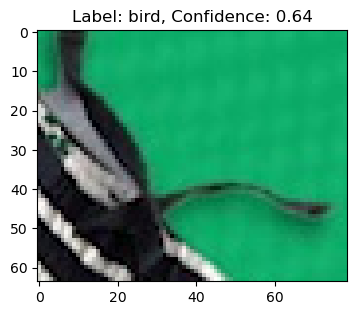

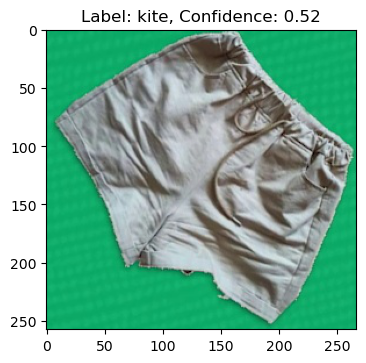

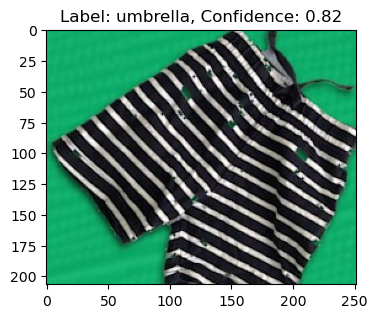

In [16]:
def process(image):
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes

    image_np = np.array(image)  # Convert the image to a NumPy array once
    height, width, _ = image_np.shape
    target_sizes = torch.tensor([[height, width]])  # Note the double square brackets

    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
    # Iterate over detected objects and process bounding boxes
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = box.detach().numpy()  # Detach tensor and convert to numpy array
        x_min, y_min, x_max, y_max = map(int, box)
        # Ensure bounding box is within image dimensions
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(width, x_max)
        y_max = min(height, y_max)


        cropped_image = image_np[y_min:y_max, x_min:x_max]
        
        # Display the cropped image
        fig, ax_cropped = plt.subplots(1, figsize=(4, 4))  # Use reasonable size for the cropped image
        ax_cropped.imshow(cropped_image)
        ax_cropped.set_title(f'Label: {model.config.id2label[label.item()]}, Confidence: {score.item():0.2f}')
        plt.show()


# Replace `image` with your actual image variable
process(image)
